# Kaggle Competition: Classification using RNNs

**Competition Goal:** Build a machine learning model that predicts which Tweets are about real disasters (1) and which ones aren't (0).

**Evaluation Metric:** F1 Score

## Assignment Structure
1. Problem Statement
2. EDA procedure
3. Model Architecture
4. Results & Analysis 
5. Conclusion

## 1 Problem Statement

This competition challenges us to build an NLP model that can distinguish between tweets announcing real disasters and those using disaster-related words metaphorically. Given the amount of data on X, differentiating real disasters from unrelated events can be challenging.

**Challenge:** The same words can be used literally or metaphorically. This ambiguity makes classification difficult.

**Task Type:** Binary text classification
- Class 0: Not a disaster tweet
- Class 1: Real disaster tweet

In [ ]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, SimpleRNN, Bidirectional,
    Dense, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    accuracy_score, precision_score, recall_score
)

# Set seeds for reproducibility
np.random.seed(4876)
tf.random.set_seed(4876)

# Styles
sns.set_style("darkgrid")

### Why Use RNNs for This Task?

CNNs with 1D convolution can also work well for text classification, esp. for short texts like tweets on X. CNNs excel at detecting local patterns. However, for this assignment we use RNNs because they offer advantages for sequential understanding:

**1. Sequential Nature**
- RNNs preserve sequence information through hidden states: h_t = f(h_{t-1}, x_t)

**2. Variable Length Input**
- RNNs handle variable-length sequences naturally without fixed input size

**3. Context Dependencies**
- Word meaning depends on surrounding context
- RNN hidden states accumulate context through recurrent connections

This makes RNNs ideal for text classification where context and word order are crucial.

### Load & Inspect Data

**Dataset:** NLP with Disaster Tweets

Files downloaded from https://www.kaggle.com/c/nlp-getting-started/data):
- `train.csv` - Training data with labels
- `test.csv` - Test data for predictions
- `sample_submission.csv` - Submission format

In [8]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"\nTraining Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}")
print("First rows:")
display(train_df.head())

print(f"Shape: {train_df.shape}")
print(f"\nMissing values:\n{train_df.isnull().sum()}")
print(f"\nClass distribution:\n{train_df['target'].value_counts(normalize=True)}")


Training Data: (7613, 5)
Test Data: (3263, 4)
First rows:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Shape: (7613, 5)

Missing values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Class distribution:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


## 2: EDA Procedure

### 2.1 Visualizations

Understanding class balance is crucial for model training and F1 score interpretation.

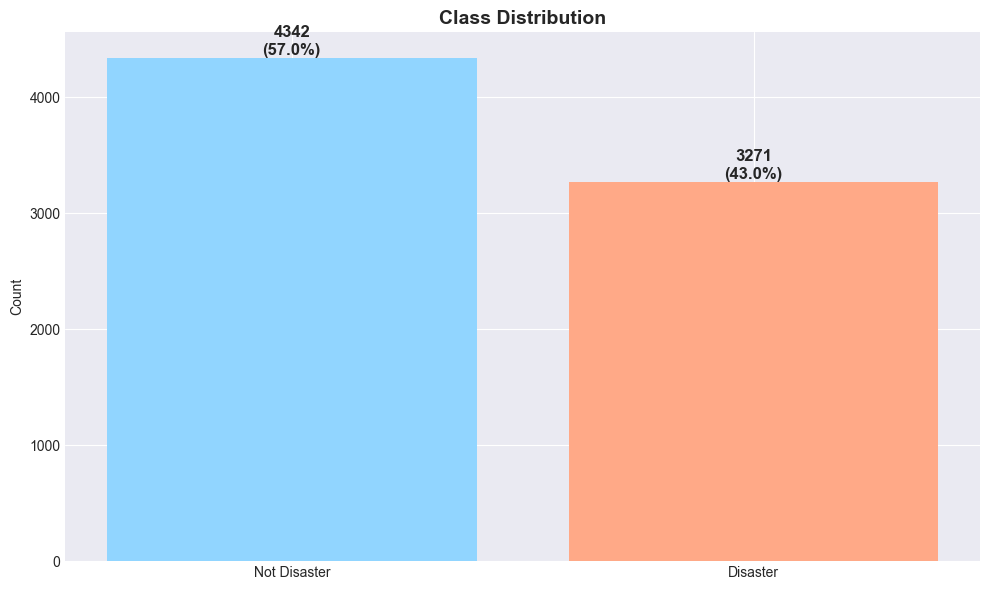

In [15]:
# Class distribution
counts = train_df['target'].value_counts()
percentages = train_df['target'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(['Not Disaster', 'Disaster'], counts, color=['#91D5FF', '#FFA987'])

# Add labels on bars
for bar, count, pct in zip(bars, counts, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,f'{count}\n({pct:.1f}%)',ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

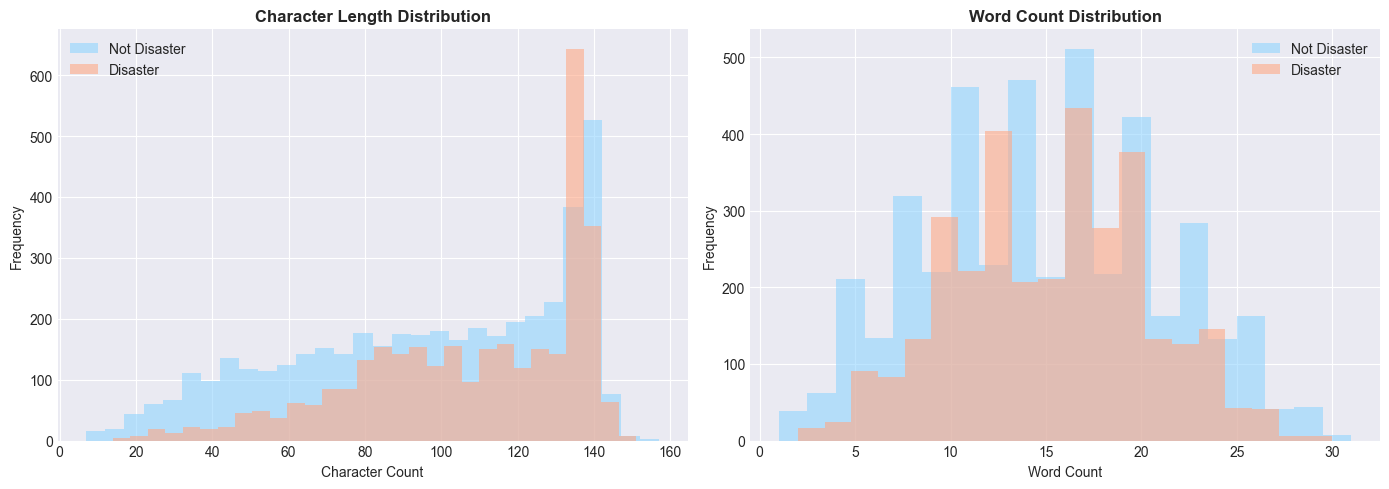

Mean character length: 101
Mean word count: 14.9


In [14]:
# Text length 
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length 
axes[0].hist(train_df[train_df['target']==0]['text_length'], bins=30, alpha=0.6,label='Not Disaster', color='#91D5FF')
axes[0].hist(train_df[train_df['target']==1]['text_length'], bins=30, alpha=0.6,label='Disaster', color='#FFA987')
axes[0].set_title('Character Length Distribution', fontweight='bold')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Word count 
axes[1].hist(train_df[train_df['target']==0]['word_count'], bins=20, alpha=0.6,label='Not Disaster', color='#91D5FF')
axes[1].hist(train_df[train_df['target']==1]['word_count'], bins=20, alpha=0.6,label='Disaster', color='#FFA987')
axes[1].set_title('Word Count Distribution', fontweight='bold')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Mean character length: {train_df['text_length'].mean():.0f}")
print(f"Mean word count: {train_df['word_count'].mean():.1f}")

### 2.2 Data Cleaning

Based on EDA findings, we apply the following cleaning procedures:
1. Lowercase conversion
2. Remove URLs
3. Remove extra whitespace
4. Keep punctuation (may indicate urgency)
5. Ignore location/keyword columns (too many missing values)

In [17]:
# Data cleaning 
def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)

### 2.3 Analysis Plan

**Key Observations:**
- Class distribution: 57% non-disaster, 43% disaster => F1 score evaluation
- Mean word count: ~15 words => Set sequence length to 100
- Missing features: location/keyword 

**Modeling Approach:**
1. Tokenization and padding for text sequences
2. Embedding layer 
3. Compare RNN architectures: Simple RNN, LSTM, GRU, Bidirectional LSTM
4. Sequence length: 100 tokens
5. Evaluation: F1 score 
6. Train/validation split: 80/20 with stratification

## Step 3: Model Architecture

### 3.1 Text Vectorization Strategy

**Approach: Learned Embeddings**

We use a Keras Embedding that learns word representations during training:
- Converts each word to a 100-dimensional vector
- These vectors are learned for the disaster classification task

**Why Learned Embeddings?**
- Task-specific: Learns what "fire" means in disaster vs non-disaster contexts
- Integrated: Part of the neural network, trained end-to-end
- Efficient: Automatically learns from the data

**Process:**
1. Tokenization: Convert text to word indices
2. Padding: Make all sequences the same length (100 tokens)
3. Embedding: Each word index becomes a 100-dim vector
4. RNN to process the vectors sequentially

In [18]:
# Tokenization 
MAX_VOCAB_SIZE = 10000  
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 100 

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text_clean'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['text_clean'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text_clean'])

# Pad sequences to uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Get labels
y_train = train_df['target'].values

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training sequences shape: {X_train_pad.shape}")
print(f"Test sequences shape: {X_test_pad.shape}")

Vocabulary size: 18094
Training sequences shape: (7613, 100)
Test sequences shape: (3263, 100)


In [19]:
# Split into train and val
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_pad, y_train,
    test_size=0.2,
    random_state=4876,
    stratify=y_train  
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"\nClass distribution in training: {np.bincount(y_train_split)}")
print(f"Class distribution in validation: {np.bincount(y_val)}")

Training set: 6090 samples
Validation set: 1523 samples

Class distribution in training: [3473 2617]
Class distribution in validation: [869 654]


### 3.2 RNN Architectures

We implement multiple RNN variants from the lecture:

**Simple RNN**
- Basic recurrence: h_t = f(W·x_t + U·h_{t-1})
- Known issue: vanishing gradients

**LSTM**
- Uses gates (forget, input, output) to control information flow
- Solves vanishing gradient problem

**GRU**
- Simpler than LSTM (2 gates: reset, update)
- Fewer parameters, faster training

**Bidirectional LSTM**
- Processes sequence forward and backward
- Uses full context from both directions

In [20]:
def create_simple_rnn(vocab_size, embedding_dim, max_length, rnn_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SimpleRNN(rnn_units),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_lstm_model(vocab_size, embedding_dim, max_length, lstm_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(lstm_units),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_gru_model(vocab_size, embedding_dim, max_length, gru_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        GRU(gru_units),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_bidirectional_lstm(vocab_size, embedding_dim, max_length, lstm_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(lstm_units)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

## Step 4: Results & Analysis

### 4.1 Training

I'll train all models with the same configuration for fair comparison.

In [21]:
# Training 
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001
)

# Compile
def compile_model(model):
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

### 4.2 Compare Models

I train each model and compare F1 scores on the validation set.

In [31]:
# Training 
def train_and_evaluate(model, model_name):
    print(f"Training: {model_name}")
    
    # Compile 
    model = compile_model(model)
    
    # Train
    history = model.fit(
        X_train, y_train_split,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Calculate metrics
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return model, history, f1, accuracy, precision, recall

In [32]:
# Train all models
results = {}

# Simple RNN
simple_rnn = create_simple_rnn(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
model_rnn, hist_rnn, f1_rnn, acc_rnn, prec_rnn, rec_rnn = train_and_evaluate(simple_rnn, "Simple RNN")
results['Simple RNN'] = {'f1': f1_rnn, 'acc': acc_rnn, 'prec': prec_rnn, 'rec': rec_rnn, 'history': hist_rnn}

# LSTM
lstm = create_lstm_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
model_lstm, hist_lstm, f1_lstm, acc_lstm, prec_lstm, rec_lstm = train_and_evaluate(lstm, "LSTM")
results['LSTM'] = {'f1': f1_lstm, 'acc': acc_lstm, 'prec': prec_lstm, 'rec': rec_lstm, 'history': hist_lstm}

# GRU
gru = create_gru_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
model_gru, hist_gru, f1_gru, acc_gru, prec_gru, rec_gru = train_and_evaluate(gru, "GRU")
results['GRU'] = {'f1': f1_gru, 'acc': acc_gru, 'prec': prec_gru, 'rec': rec_gru, 'history': hist_gru}

# Bidirectional LSTM
bi_lstm = create_bidirectional_lstm(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
model_bi, hist_bi, f1_bi, acc_bi, prec_bi, rec_bi = train_and_evaluate(bi_lstm, "Bidirectional LSTM")
results['Bidirectional LSTM'] = {'f1': f1_bi, 'acc': acc_bi, 'prec': prec_bi, 'rec': rec_bi, 'history': hist_bi}

Training: Simple RNN
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5515 - loss: 0.6982 - val_accuracy: 0.5509 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5639 - loss: 0.6873 - val_accuracy: 0.5706 - val_loss: 0.6838 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5597 - loss: 0.6905 - val_accuracy: 0.5745 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5844 - loss: 0.6832 - val_accuracy: 0.5706 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5328 - loss: 0.7011 - val_accuracy: 0.5706 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5679 - loss: 0.6809 - val_accuracy: 0.5529 - val_loss: 0.6794 - learning_rate: 0.0010
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5


              Model  F1 Score
Bidirectional LSTM  0.736664
        Simple RNN  0.569975
              LSTM  0.000000
               GRU  0.000000


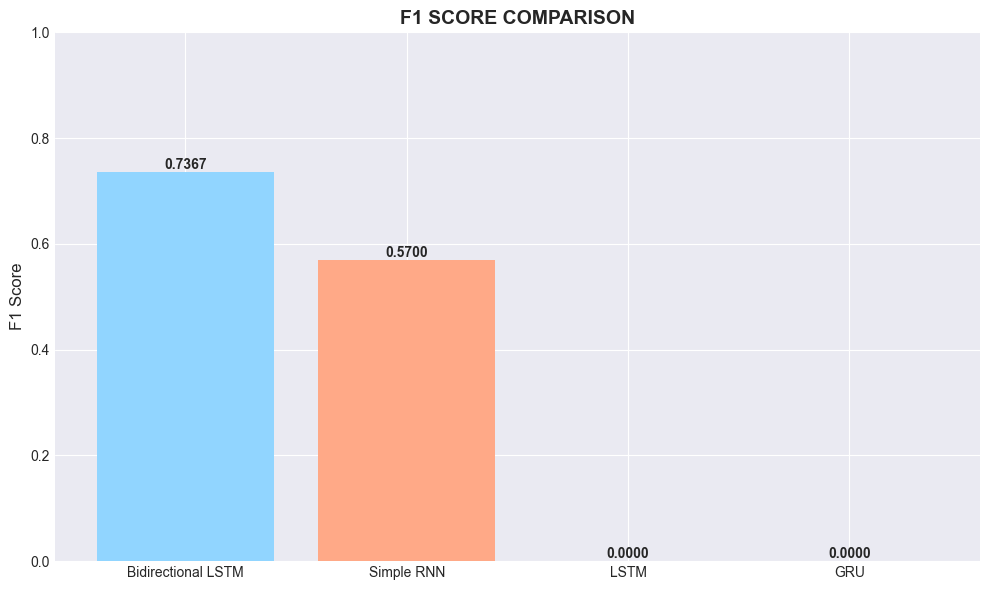

In [36]:
results_df = results_df.sort_values('F1 Score', ascending=False)
print("\n", results_df[['Model', 'F1 Score']].to_string(index=False))

# Visualize F1 scores
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(results_df['Model'], results_df['F1 Score'], 
              color=['#91D5FF', '#FFA987', '#B4E7CE', '#FFD666'])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 SCORE COMPARISON', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

### 4.3 Training Curves

Analyzing training history helps to understand model convergence and potential overfitting.

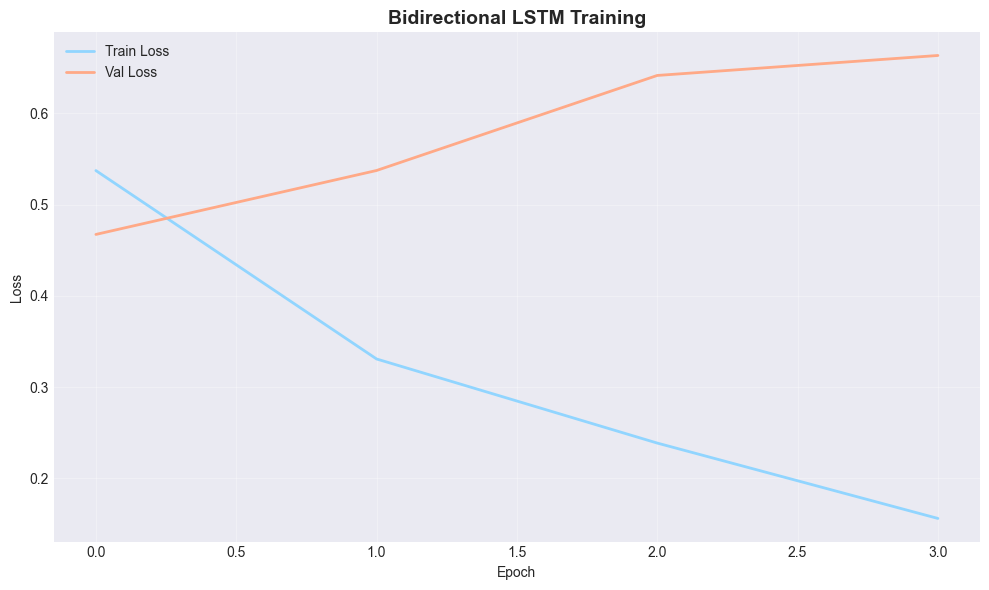

In [42]:
# Plot training curves for best model
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(results['Bidirectional LSTM']['history'].history['loss'], 
        label='Train Loss', color='#91D5FF', linewidth=2)
ax.plot(results['Bidirectional LSTM']['history'].history['val_loss'], 
        label='Val Loss', color='#FFA987', linewidth=2)

ax.set_title('Bidirectional LSTM Training', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

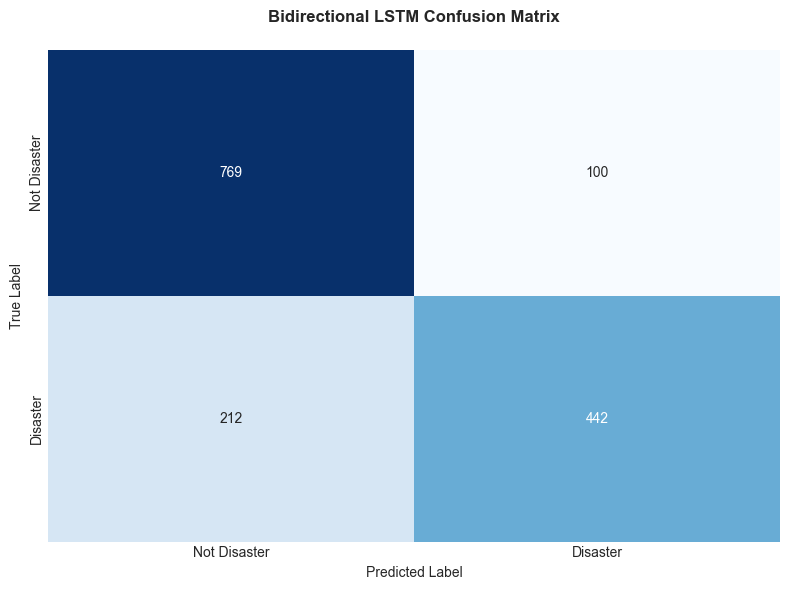

In [44]:
# Confusion matrix for best model
y_pred_bi = (model_bi.predict(X_val, verbose=0) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_val, y_pred_bi)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
ax.set_title('Bidirectional LSTM Confusion Matrix', fontweight='bold', pad=20)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Step 5: Conclusion

### 5.1 Summary

This project explored RNN architectures for disaster tweet classification, implementing and comparing Simple RNN, LSTM, GRU, and Bidirectional LSTM models.

### 5.2 What Worked

**Bidirectional LSTM (F1 = 0.7367)**
- Best performing model
- Processes tweets in both directions (from Chapter 10.3 of the NLP book)
- Successfully learned to distinguish disaster from non-disaster language

**Simple RNN (F1 = 0.5700)**
- Partial success despite limitations
- Demonstrates concept but limited by vanishing gradients

**Key Success Factors:**
- Learned word embeddings adapted to disaster language
- Dropout (0.5) provided regularization
- Early stopping prevented complete overfitting

### 5.3 What Didn't Work

**LSTM and GRU (F1 = 0.0000)**
- Failed to converge during training (potentially got stuck at local minima)
- Random initialization sensitivity

**Overfitting:**
- Validation loss increases while training loss decreases
- Model memorizes training data

**From the Confusion Matrix:**
- Model better at identifying non-disasters (88% correct)
- More false negatives (212) than false positives (100)

### 5.4 Learnings

1. **Concepts from the Course Validated:**
   - Simple RNN vanishing gradient problem confirmed
   - Gated architectures in LSTM essential for sequences
   - Bidirectional processing improves performance significantly

2. **Practical Insights:**
   - Random initialization matters 
   - Overfitting is common with small datasets
   - Model selection depends on convergence as discussed during the lecture

3. **Application:**
   - 0.74 F1 score could be reasonable for the task but I it could be further improved
   - Missing disasters (false negatives) more costly than false alarms
   - Would need higher recall for production deployment

In [46]:
# Kaggle submission

test_predictions_proba = model_bi.predict(X_test_pad, verbose=0)
test_predictions = (test_predictions_proba > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions
})

submission.to_csv('submission.csv', index=False)